# Area Aggregation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
DIR = "/workspace/nflbigdatabowl2023"
sys.path.append(DIR)

## Visualization Preparation

Import the visualizers and provide the data to power them.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt

from ast import literal_eval

from src.visualization.formations import (
    plot_area_distributions,
    get_formation_distribution_plotter,
    get_all_formation_distributions_plotter,
)
from src.visualization.helpers import unsnake, make_dropdown
from src.visualization.interactive_play_selector import create_interactive_play_selector
from src.visualization.logos import get_team_logos
from src.visualization.scatter import get_team_scatter_plotter, get_team_scatter_ranker

In [4]:
team_logos = get_team_logos()

In [5]:
df_play_metrics_all = pd.read_csv(f"{DIR}/data/processed/play_metrics.csv")
df_plays_all = pd.read_csv(f"{DIR}/data/raw/plays.csv")

In [6]:
df_median_areas = df_play_metrics_all.query("window_type == 'before_end'")
df_plays_all["offenseFormation"] = df_plays_all["offenseFormation"].fillna("MISSING")
df_play_info = df_median_areas.merge(df_plays_all, on=["gameId", "playId"], how="left")
formations = list(df_play_info["offenseFormation"].unique())
area_methods = list(df_play_info["method"].unique())
x_max = df_median_areas["median_area"].max()

In [7]:
plot_formation_distribution = get_formation_distribution_plotter(df_play_info, formations, x_max)
plot_all_formation_distributions = get_all_formation_distributions_plotter(df_play_info, formations)
rank_team_scatter = get_team_scatter_ranker(df_play_info)
plot_team_scatter = get_team_scatter_plotter(df_play_info, team_logos)

## Example Visualizations

These visualizations are not interactive, so they will be rendered in the notebook output. You can change them by changing their input variables.

In [8]:
default_area = "voronoi_pocket_area"
default_formation = "SHOTGUN"

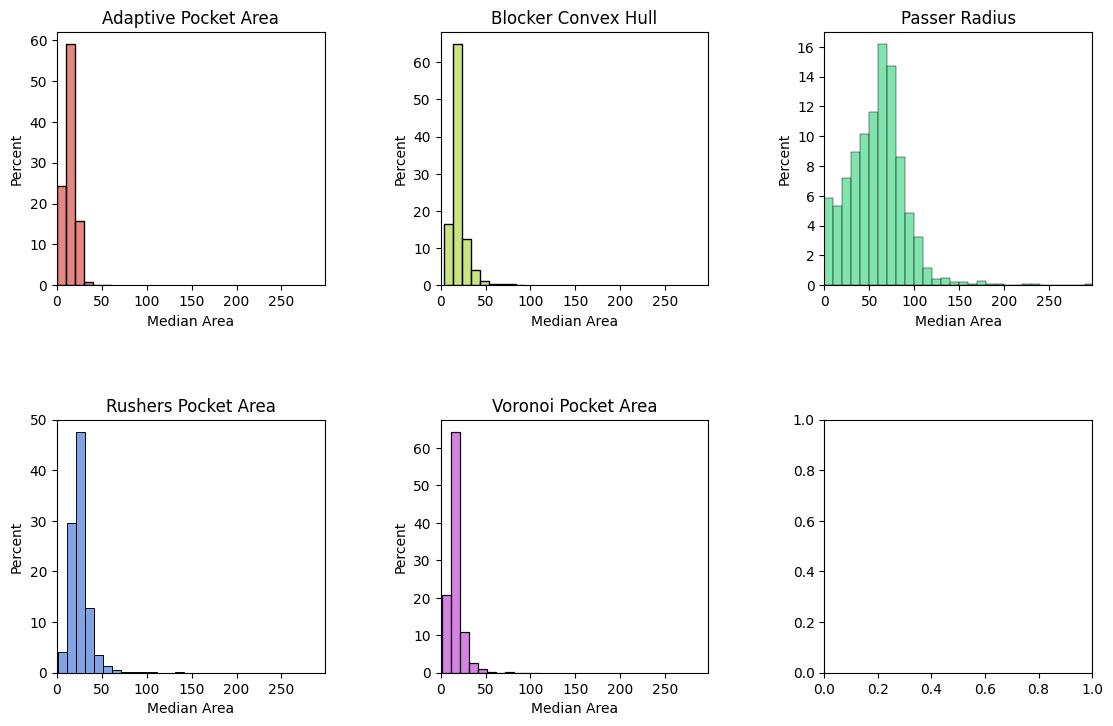

In [9]:
plot_area_distributions(df_median_areas)

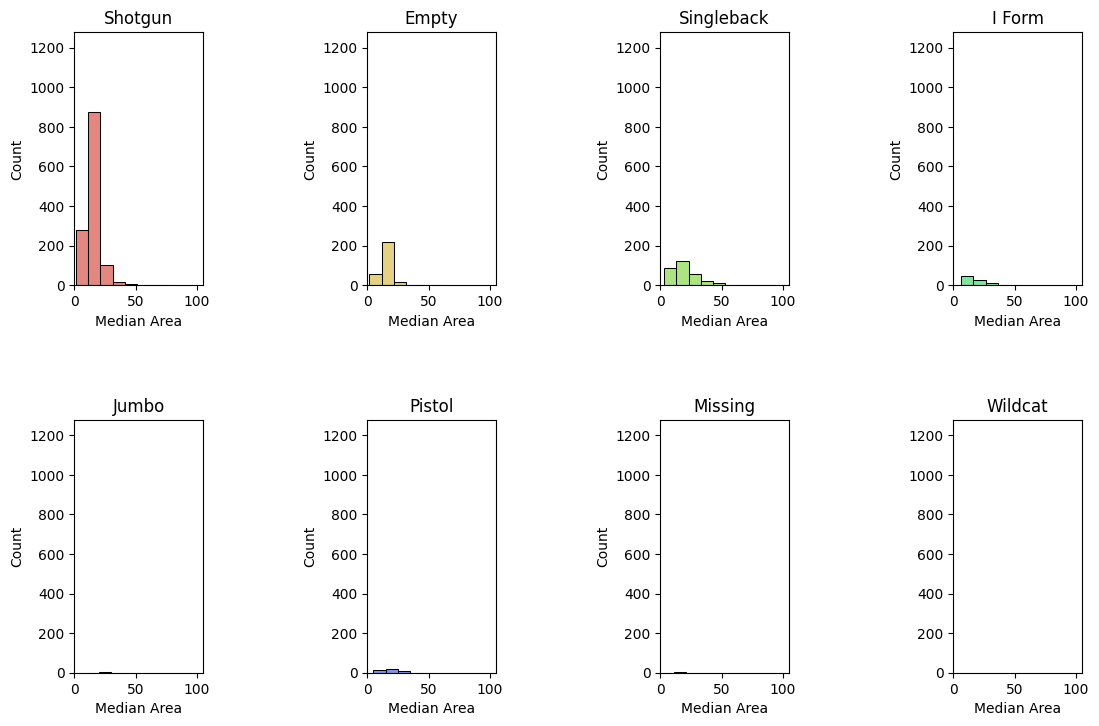

In [10]:
plot_all_formation_distributions(default_area)

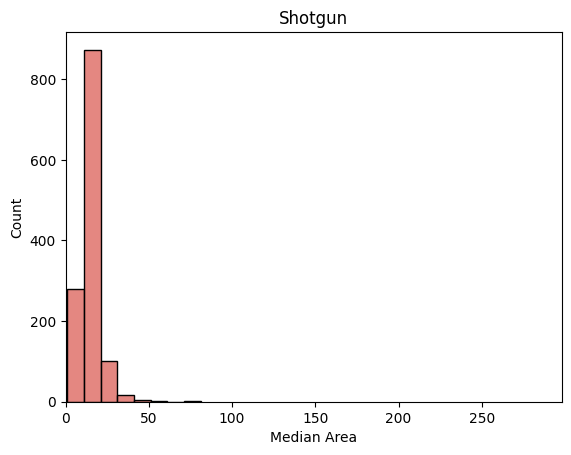

In [11]:
plot_formation_distribution(default_area, default_formation)

In [12]:
rank_team_scatter(default_area, default_formation)

,index,team,plays,median_area,median_time_in_pocket,sack_rate
0,15,KC,30,18.115893,3.05,0.066667
1,12,HOU,35,17.283139,3.10,0.028571
2,0,ARI,39,17.100817,3.30,0.051282
3,3,BUF,46,16.556850,3.00,0.043478
4,22,NO,32,16.184128,2.95,0.062500
5,7,CLE,21,16.154495,3.80,0.142857
6,29,TB,40,15.565622,2.70,0.075000
7,21,NE,33,15.512716,2.70,0.060606
8,28,SF,16,15.422778,2.55,0.000000
9,2,BAL,26,15.377290,3.25,0.153846


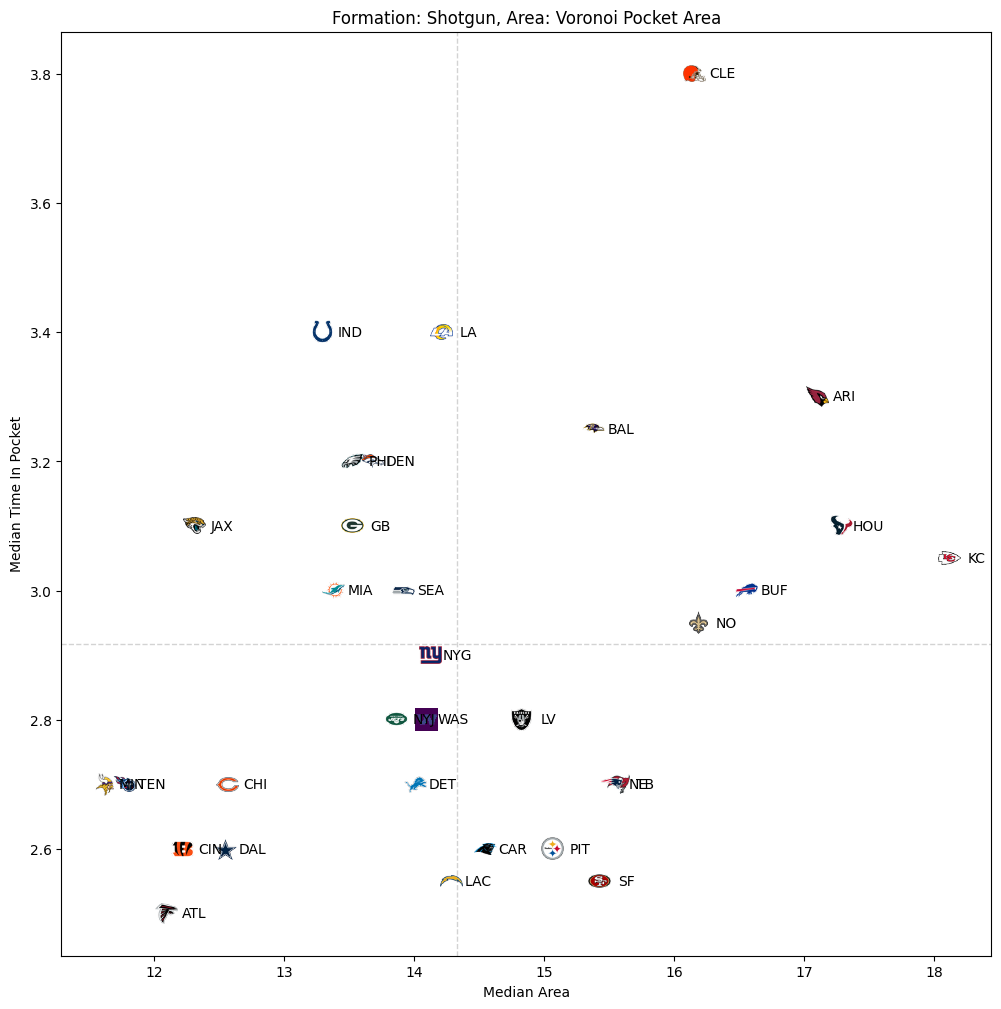

In [13]:
plot_team_scatter(default_area, default_formation, "median_area", "median_time_in_pocket")

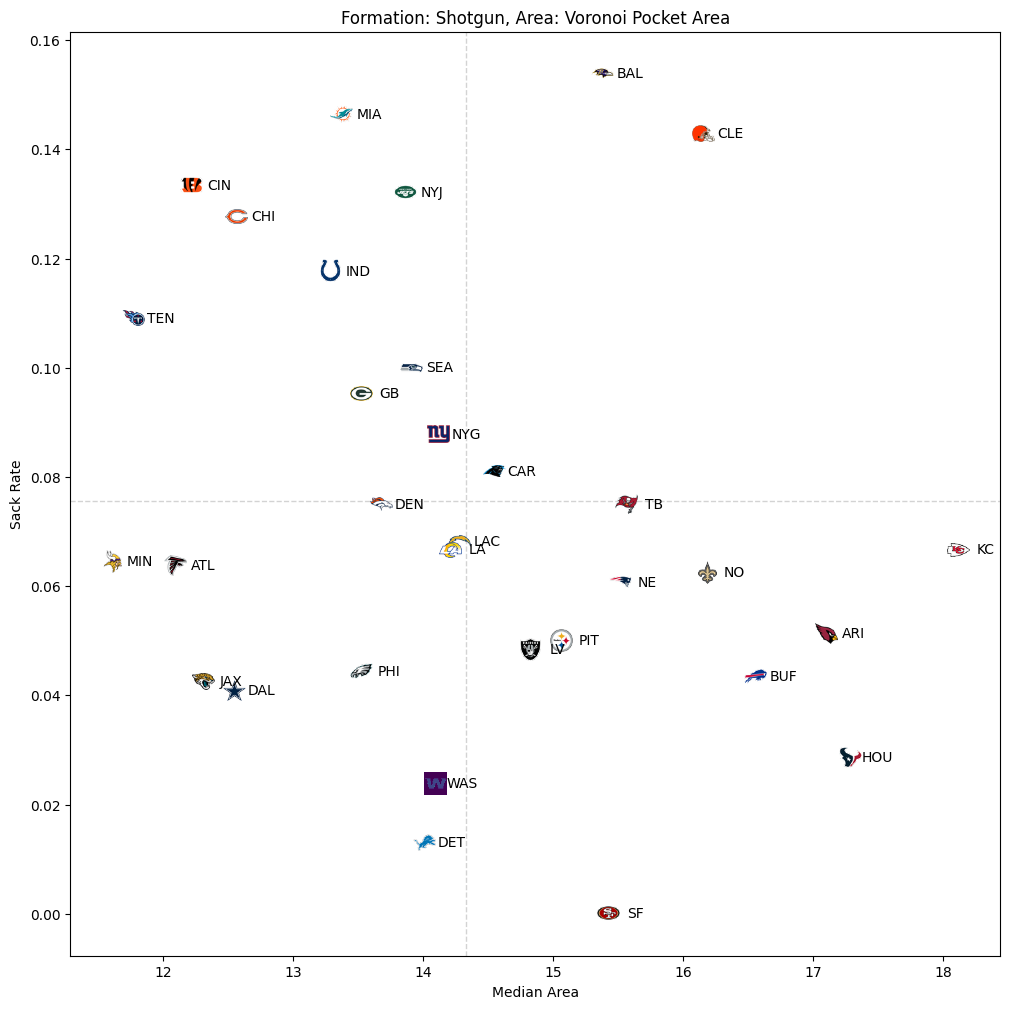

In [14]:
plot_team_scatter(default_area, default_formation, "median_area", "sack_rate")

## Interactive Visualizations

These visualizations are interactive, so you can play with them, but they will not be rendered in the notebook output.

In [15]:
_ = widgets.interact(
    plot_all_formation_distributions,
    method=make_dropdown(area_methods, "Area"),
)

interactive(children=(Dropdown(description='Area', options=('adaptive_pocket_area', 'blocker_convex_hull', 'pa…

In [16]:
_ = widgets.interact(
    plot_formation_distribution,
    method=make_dropdown(area_methods, "Area"),
    formation=make_dropdown(formations, "Formation"),
)

interactive(children=(Dropdown(description='Area', options=('adaptive_pocket_area', 'blocker_convex_hull', 'pa…

In [17]:
_ = widgets.interact(
    rank_team_scatter,
    method=make_dropdown(area_methods, "Area"),
    formation=make_dropdown(formations, "Formation"),
)

interactive(children=(Dropdown(description='Area', options=('adaptive_pocket_area', 'blocker_convex_hull', 'pa…

In [18]:
_ = widgets.interact(
    plot_team_scatter,
    method=make_dropdown(area_methods, "Area"),
    formation=make_dropdown(formations, "Formation"),
    col_x=make_dropdown(["median_area"], "X"),
    col_y=make_dropdown(["median_time_in_pocket", "sack_rate"], "Y"),
)

interactive(children=(Dropdown(description='Area', options=('adaptive_pocket_area', 'blocker_convex_hull', 'pa…